# ManualAIze development

In [60]:
import os
import getpass
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser 
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools



In [ ]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [3]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")


In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Certification - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Let's start building the agent

This agent main goal is to parse and retrieve information from user manuals uploaded by the user. The first step will always be retrieval potentially augmented by internet searches. The outile of the agentic loop is the following

1. User uploads pdfs 
2. User inputs a question
3. Agent cycle starts
    - a. retrieve most relevant information from the uploaded pdfs
    - b. router agent evaluates if there is enough context
        - i. if not, calls tavily search
    - c. once it has enough context calls the writer node

### Set up the retrieval node
Let's start with parsing, embedding and storing the pdfs using Qdrant

In [79]:
import glob
import time
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Get all PDF files in the data directory
pdf_files = glob.glob("./data/*.pdf")
print(f"Found {len(pdf_files)} PDF files:")
for file in pdf_files:
    print(f"  - {file}")

# Load all PDF files with PyPDF (much faster!)
all_documents_pypdf = []
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

for pdf_file in pdf_files:
    try:
        print(f"\nLoading {pdf_file}...")
        start_time = time.time()
        
        # PyPDFLoader is MUCH faster than UnstructuredPDFLoader
        loader = PyPDFLoader(pdf_file)
        pages = loader.load()
        
        # Split into smaller chunks for better retrieval
        documents = text_splitter.split_documents(pages)
        
        elapsed = time.time() - start_time
        all_documents_pypdf.extend(documents)
        print(f"✓ Loaded {len(pages)} pages → {len(documents)} chunks in {elapsed:.1f}s")
        
    except Exception as e:
        print(f"✗ Error loading {pdf_file}: {e}")

print(f"\nTotal documents: {len(all_documents_pypdf)}")

Found 3 PDF files:
  - ./data/2024-odyssey.pdf
  - ./data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf
  - ./data/2022-mazda-mazda6.pdf

Loading ./data/2024-odyssey.pdf...
✓ Loaded 702 pages → 1210 chunks in 33.8s

Loading ./data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf...
✓ Loaded 100 pages → 143 chunks in 4.0s

Loading ./data/2022-mazda-mazda6.pdf...
✓ Loaded 702 pages → 1466 chunks in 12.3s

Total documents: 2819


In [80]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    all_documents_pypdf,
    embeddings,
    location=":memory:",
    collection_name="Manuals"
)

### Now let's create the retrieval node

This is not RAG. I want this node to just fetch the information

In [81]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

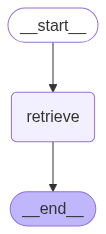

In [82]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class RetrievalState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

def retrieve(state: RetrievalState) -> RetrievalState:
    retrieved_docs = compression_retriever.invoke(state["messages"][-1].content)  # Get question from last message
    
    # Convert Documents to messages
    context_message = f"Retrieved context from documents:\n"
    for i, doc in enumerate(retrieved_docs):
        context_message += f"\n--- Document {i+1} ---\n{doc.page_content}\n"
    
    return {
        "messages": [
            HumanMessage(content="Retrieval agent responding:"),
            AIMessage(content=context_message, name="Retrieval")
        ]
    }

graph_builder = StateGraph(RetrievalState)
graph_builder = graph_builder.add_sequence([retrieve])
graph_builder.add_edge(START, "retrieve")
retrieval_graph = graph_builder.compile()

retrieval_graph

In [83]:
def retrieval_enter_chain(question: str):
    return {
        "messages": [HumanMessage(content=question["question"])],
        "team_members": ["Search", "Writer"],
        "next": ""
    }

full_test_chain = retrieval_enter_chain | retrieval_graph

full_test_chain.invoke({"question" : "What are the front facing height and weight limits for the car seat?"})

{'messages': [HumanMessage(content='What are the front facing height and weight limits for the car seat?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Retrieval agent responding:', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Retrieved context from documents:\n\n--- Document 1 ---\n15\n  When Using This Car Seat \nin Forward-Facing Mode\nP Child’s weight is between 22 and 65 lb \n(10 and 29.5 kg).\nP Child’s height is between 30 and 49 in. \n(76 and 124 cm).\nP Child is at least 1 year of age.\nP Car seat is securely installed in a rear \nvehicle seating position using either the \nrigid LATCH Connectors and the Top \nTether; the vehicle belt and Top Tether; or \nthe rigid LATCH Connectors, the vehicle \nbelt, and the Top Tether.\nNOTE: If child weighs more than 35 lb \n(15.9 kg), this car seat must be installed \neither with the vehicle belt and the Top \nTether or with the rigid LATCH lower \nconnectors, the vehicle belt, and the \nTop Te

### Helper functions
Now I am going to create helper functions to help me quickly build the nodes, the graph and the connections between them.We will have our helper accepts the following parameters:


- llm: the llm that will power this agent node
- tools: the list of tools available to the llm
- system_prompt: the system prompt to attach to the llm to ground its generation

In [84]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    # Extract the actual output text from the agent result
    if isinstance(result, dict):
        output_text = result.get('output', str(result))
    else:
        output_text = str(result)
    
    # Return two messages: one identifying the agent, one with its response
    return {
        "messages": [
            HumanMessage(content=f"{name} agent responding:"),
            AIMessage(content=output_text, name=name)
        ]
    }

In [85]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [86]:
def create_router(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    
    tool_def = {
        "type": "function",
        "function": {
            "name": "route",
            "description": "Select the next role.",
            "parameters": {
                "type": "object",
                "properties": {
                    "next": {
                        "type": "string",
                        "enum": options,
                    },
                },
                "required": ["next"],
            },
        }
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    
    
    return (
        prompt
        | llm.bind_tools([tool_def], tool_choice={"type": "function", "function": {"name": "route"}})
        | JsonOutputToolsParser()
    )

### Create the tools
For this application we need only tavily.

Tavily search for which we can just pull the implemented API from the library. 

If we were to create a custom tool we would just need to define  a function that calls the node and add the tool decorator. There is an example below, however we are not going to use it

In [87]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
]

In [88]:
@tool
def search_internet(query: Annotated[str, "Query to search the internet for"]):
    """Search the internet for additional information"""
    # Use your existing tavily_tool
    results = tavily_tool.invoke(query)
    
    # Convert results to Document format
    from langchain_core.documents import Document
    docs = []
    for result in results:
        content = f"Title: {result.get('title', '')}\nContent: {result.get('content', '')}\nURL: {result.get('url', '')}"
        docs.append(Document(page_content=content, metadata={"source": "internet_search", "url": result.get('url', '')}))
    
    return docs

### Let's define the state functions

First let's define what we want to keep track of at every step of the execution.

- messages: The messages we've passed so far
- team_members: which team members we have access to
- next: what team member is up next

### Now it is time to define the orchestrator node, the router in this case

The router will receive the context from the retrieval and then decide whether it should call tavily or pass the context directly to the writer

In [89]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### It is finally time to define the agents
As a recap, we need:
- a retrieval node, which we already have
- a router/orchestrator agent that can either call the search or writer agent
- a search agent
- a writer agent

In [90]:


search_agent = create_agent(
    llm, 
    [search_internet], 
    "You are a research assistant who can search for details to asnwer the user query."
    )

# search_node = functools.partial(agent_node, agent=search_agent, name="Search")

def search_agent_node(state, agent, name):
    result = agent.invoke(state)
    
    # Extract the search results (already Documents from your tool)
    if isinstance(result, dict):
        output_text = result.get('output', str(result))
        # If output contains Documents, format them
        if hasattr(result.get('output'), '__iter__') and all(hasattr(item, 'page_content') for item in result.get('output')):
            search_message = f"Internet search results:\n"
            for i, doc in enumerate(result.get('output')):
                search_message += f"\n--- Result {i+1} ---\n{doc.page_content}\n"
        else:
            search_message = output_text
    else:
        search_message = str(result)
    
    return {
        "messages": [
            HumanMessage(content=f"{name} agent responding:"),
            AIMessage(content=search_message, name=name)
        ]
    }

search_node = functools.partial(search_agent_node, agent=search_agent, name="Search")

In [98]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# Create a specific prompt and chain for the writer
# This is a much simpler setup than a full agent
writer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a writer. Use the provided context to answer the user's question clearly and accurately."),
        ("user", "Question: {question}\n\nContext:\n{context}")
    ]
)
writer_chain = writer_prompt | llm | StrOutputParser()

def writer_node(state):
    """
    The writer node. It takes the state, combines the context,
    and generates the final answer.
    """
    # Combine all context from messages
    combined_context = ""
    for msg in state["messages"]:
        if isinstance(msg, AIMessage) and msg.name in ["Retrieval", "Search"]:
            combined_context += f"\n{msg.content}\n"
            
    # The first message is always the user's original question
    question = state["messages"][0].content
    
    # Invoke the writer chain
    result = writer_chain.invoke({"question": question, "context": combined_context})
    
    return {
        "messages": [
            HumanMessage(content="Writer agent responding:"),
            AIMessage(content=result, name="Writer")
        ]
    }

In [99]:
router_agent = create_router(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, Writer. Given the following user request,"
    " determine if the information is enough to answer the user query. If it is,"
    " pass the context to Writer. If it is not, pass the query to Search."
    " You should never ask Search to do anything beyond research."
    " You should never ask Writer to do anything beyond writing the answer given"
    " the context."),
    ["Search", "Writer"],
)

In [100]:
def router_node(state):
    # Extract messages from the state
    messages = state["messages"]
    
    # Call the router chain with proper input
    result = router_agent.invoke({"messages": messages})
    
    # The new parser returns a list of tool calls. We'll take the first one.
    # The result looks like: [{'type': 'route', 'args': {'next': 'Writer'}}]
    # So we access the arguments of the first tool call.
    return {
        **state, 
        "next": result[0]["args"]["next"]
    }

# def router_node(state):
#     # Extract messages from the state
#     messages = state["messages"]
    
#     # Temporarily create a chain without the parser to see the raw output
#     # router_agent is a RunnableSequence, so we can access its parts
#     unparsed_router = router_agent.first | router_agent.middle[0]
    
#     # Let's see what the model is thinking
#     print("--- Router Input Messages ---")
#     for msg in messages:
#         print(msg)
    
#     raw_result = unparsed_router.invoke({"messages": messages})
    
#     print("\n--- Raw Router Output ---")
#     print(raw_result)
#     print("---------------------------\n")

#     # Call the router chain with proper input
#     result = router_agent.invoke({"messages": messages})
    
#     # Extract the routing decision and update state
#     return {
#         **state, 
#         "next": result["next"]
#     }

### Let's assemble the graph!

In [101]:
graph = StateGraph(RetrievalState)

# Add nodes
graph.add_node("Retrieve", retrieve)
graph.add_node("Router", router_node)
graph.add_node("Search", search_node)
graph.add_node("Writer", writer_node)

# Set entry point
graph.set_entry_point("Retrieve")

# Add edges
graph.add_edge("Retrieve", "Router")
graph.add_conditional_edges(
    "Router",
    lambda x: x["next"],
    {
        "Search": "Search",
        "Writer": "Writer",
    }
)
graph.add_edge("Search", "Writer")
graph.add_edge("Writer", END)

# Compile
compiled_graph = graph.compile()

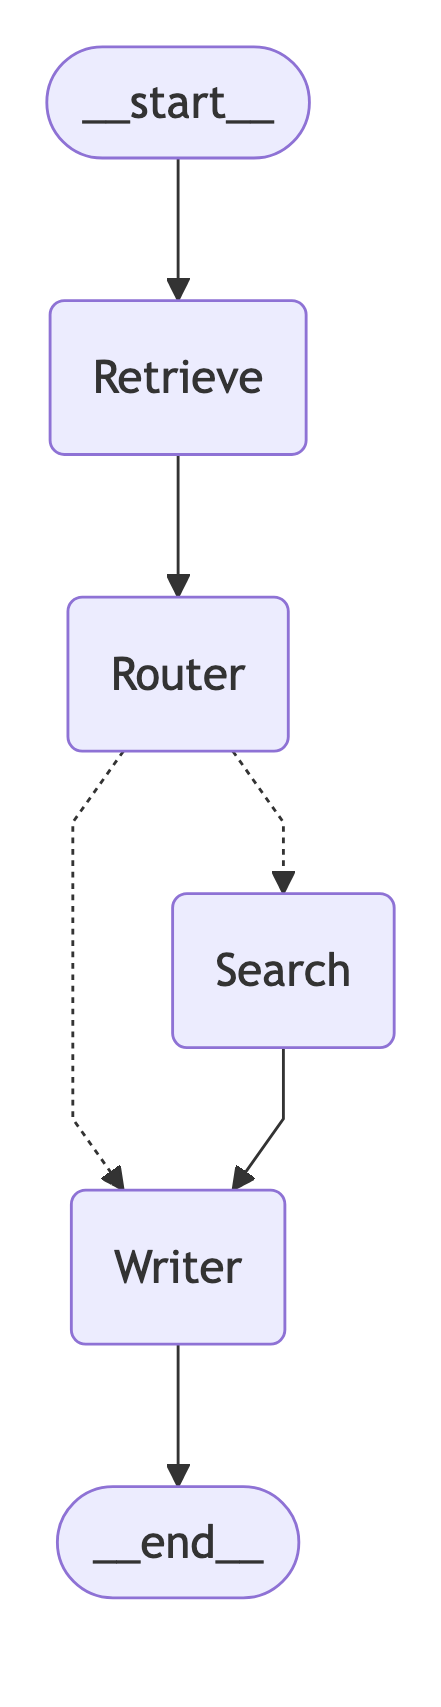

In [102]:
import nest_asyncio
nest_asyncio.apply()

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [103]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ["Search", "Writer"], 
        "next": "",                           
    }
    return results

research_chain = enter_chain | compiled_graph

In [104]:
for s in research_chain.stream(
    "What is the weight and height limits for the car seat when front facing?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Retrieve': {'messages': [HumanMessage(content='Retrieval agent responding:', additional_kwargs={}, response_metadata={}), AIMessage(content='Retrieved context from documents:\n\n--- Document 1 ---\n15\n  When Using This Car Seat \nin Forward-Facing Mode\nP Child’s weight is between 22 and 65 lb \n(10 and 29.5 kg).\nP Child’s height is between 30 and 49 in. \n(76 and 124 cm).\nP Child is at least 1 year of age.\nP Car seat is securely installed in a rear \nvehicle seating position using either the \nrigid LATCH Connectors and the Top \nTether; the vehicle belt and Top Tether; or \nthe rigid LATCH Connectors, the vehicle \nbelt, and the Top Tether.\nNOTE: If child weighs more than 35 lb \n(15.9 kg), this car seat must be installed \neither with the vehicle belt and the Top \nTether or with the rigid LATCH lower \nconnectors, the vehicle belt, and the \nTop Tether. \nP Car Seat is properly assembled with  \nthe headrest properly secured. The  \nRear-Facing Base and Anti-Rebound  \nBar m

### IT WORKS!